In [1]:
import os
import re
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:

np.random.seed(0)

#Дефинирање големина на сликата
SIZE = 256

# Функција за намалување на резолуцијата на сликата со бикубична интеролација
def downsample_image(img, scale=2):
    h, w, _ = img.shape
    img = resize(img, (h // scale, w // scale), anti_aliasing=True, mode='reflect')
    img = resize(img, (h, w), anti_aliasing=True, mode='reflect')
    return img


In [3]:
# Вчитување високорезолуциски и нискорезолуциски слики
high_img, low_img = [], []
path_high = '/content/high_res'
path_low = '/content/low_res'

files = sorted(os.listdir(path_high))
for file in files:
    if file.endswith('.png'):
        img = cv2.imread(os.path.join(path_high, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img)
        low_img.append(downsample_image(img))  # користење на функцијата со бикубична интерполација

high_img, low_img = np.array(high_img), np.array(low_img)


In [4]:
#Делење на податочното множество
split_train = int(len(high_img) * 0.7)
split_val = int(len(high_img) * 0.85)
train_high, train_low = high_img[:split_train], low_img[:split_train]
val_high, val_low = high_img[split_train:split_val], low_img[split_train:split_val]
test_high, test_low = high_img[split_val:], low_img[split_val:]

In [5]:
# Дефинирање на SRCNN моделот
input_img = Input(shape=(SIZE, SIZE, 3))
l1 = Conv2D(64, 9, padding='same', activation='relu')(input_img)
l2 = Conv2D(64, 3, padding='same', activation='relu')(l1)
l3 = Conv2D(32, 3, padding='same', activation='relu')(l2)
l4 = Conv2D(3, 5, padding='same', activation='linear')(l3)
SRCNN = Model(input_img, l4)

# Дефинирање PSNR метрики
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,411 (286.76 KB)

 Trainable params: 73,411 (286.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 171s 19s/step - loss: 0.1332 - psnr_metric: 11.7093 - val_loss: 0.0180 - val_psnr_metric: 18.2178
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 204s 19s/step - loss: 0.0153 - psnr_metric: 18.9019 - val_loss: 0.0152 - val_psnr_metric: 18.9794
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 193s 18s/step - loss: 0.0140 - psnr_metric: 19.3162 - val_loss: 0.0125 - val_psnr_metric: 19.9078
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 200s 18s/step - loss: 0.0110 - psnr_metric: 20.2697 - val_loss: 0.0095 - val_psnr_metric: 20.9916
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 209s 19s/step - loss: 0.0095 - psnr_metric: 21.0077 - val_loss: 0.0078 - val_psnr_metric: 21.6260
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 200s 19s/step - loss: 0.0086 - psnr_metric: 21.2460 - val_loss: 0.0067 - val_psnr_metric: 22.2765
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 199s 18s/step - loss: 0.0061 - psnr_metric: 22.7030 - val_loss: 0.0054 - val_psnr_metric: 23.2281
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 209s 19s/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


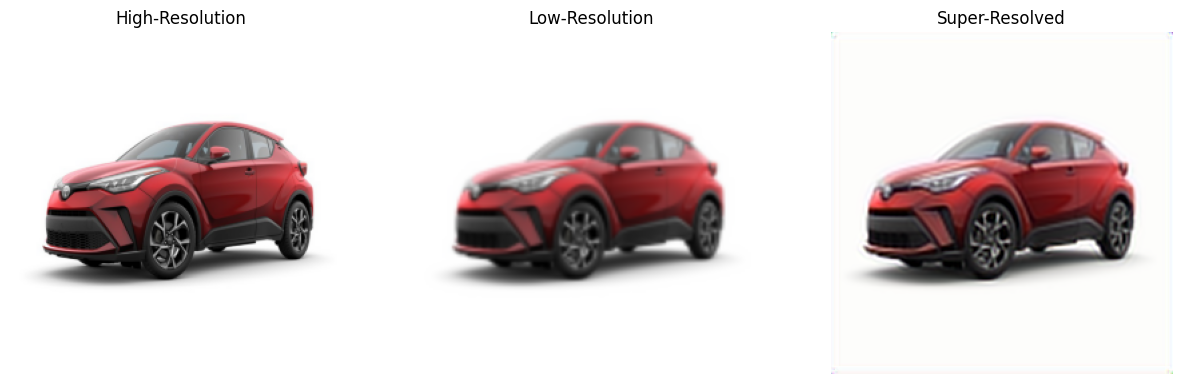

PSNR: 30.788881 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


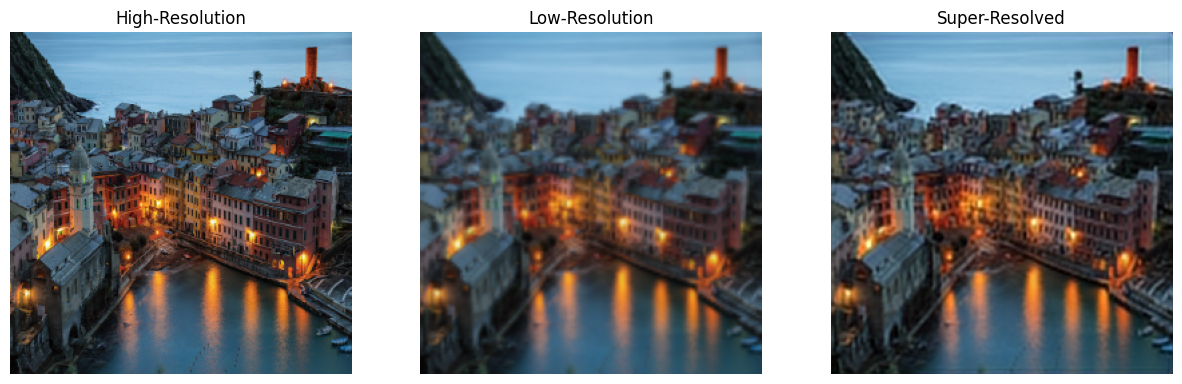

PSNR: 26.424429 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


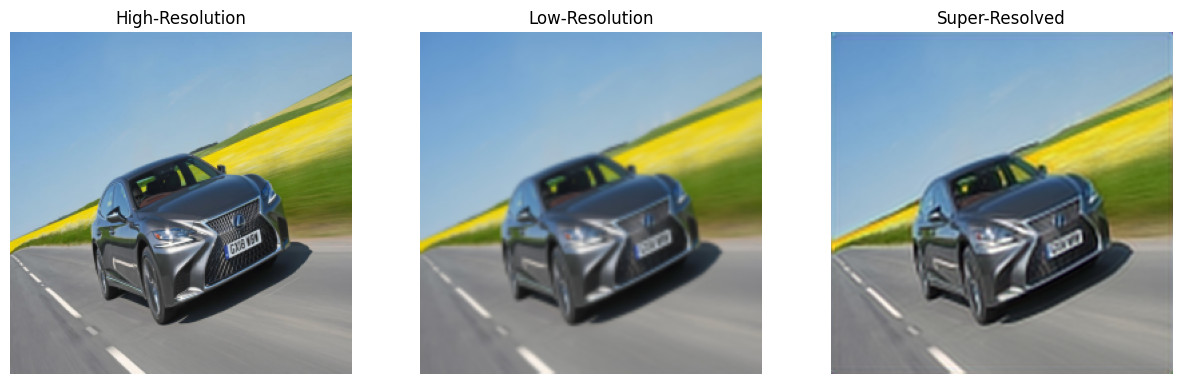

PSNR: 29.75364 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


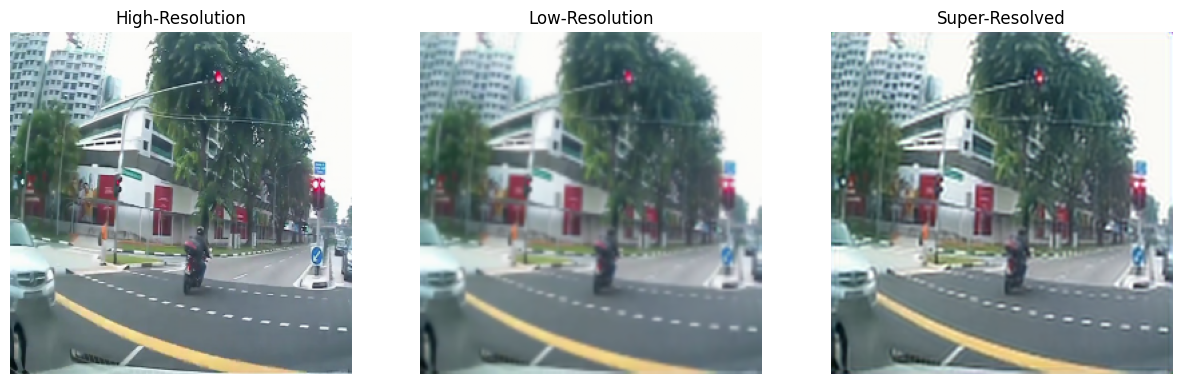

PSNR: 25.909445 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


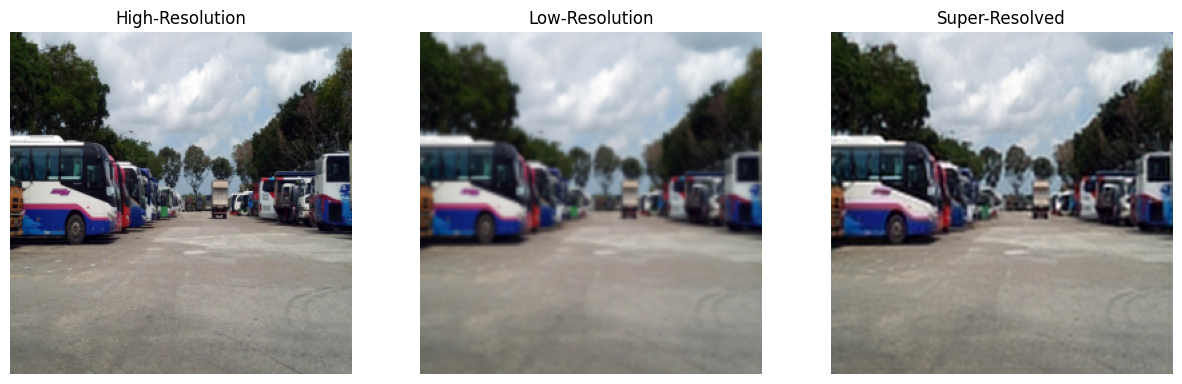

PSNR: 28.669397 dB


In [ ]:
# Компајлирање на моделот
SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=[psnr_metric])
SRCNN.summary()

# Тренирање на моделот
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
SRCNN.fit(train_low, train_high, epochs=100, batch_size=16, validation_data=(val_low, val_high), callbacks=[early_stopping])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


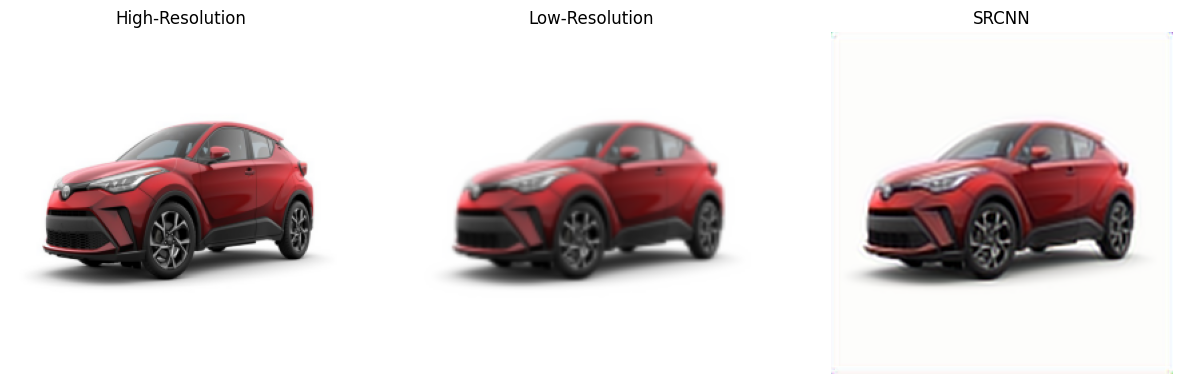

PSNR: 30.788881 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


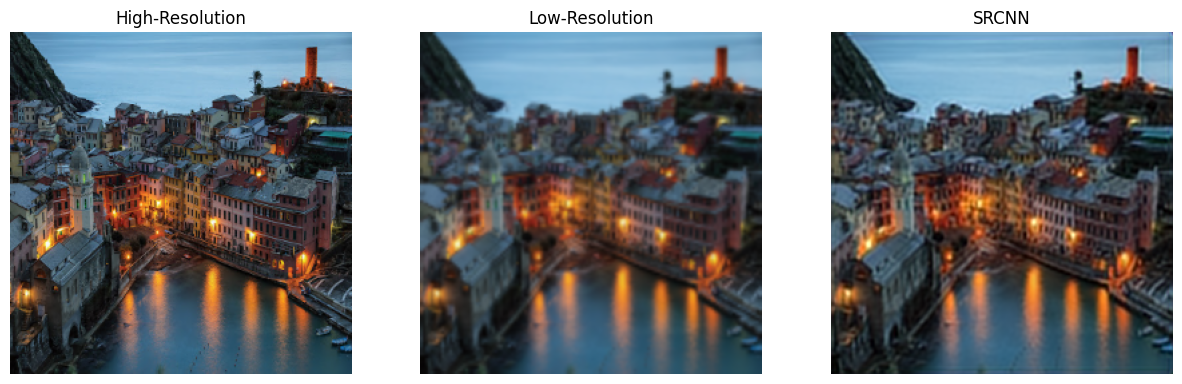

PSNR: 26.424429 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


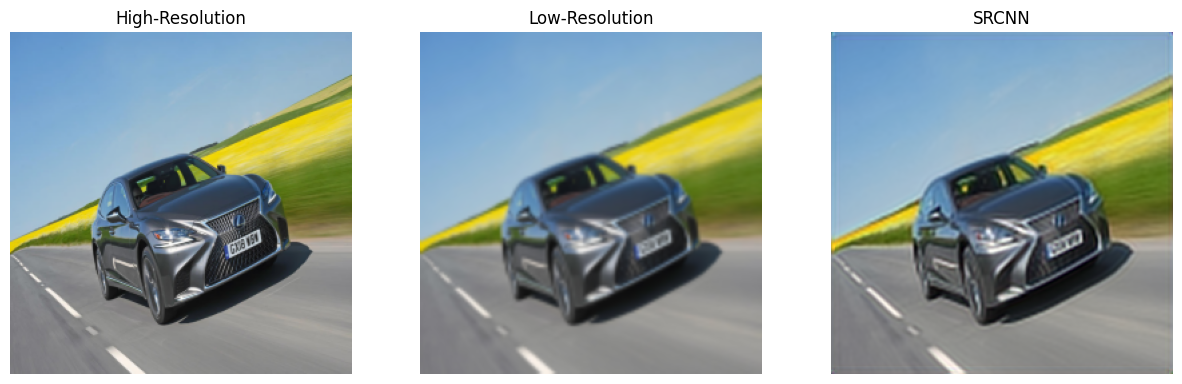

PSNR: 29.75364 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


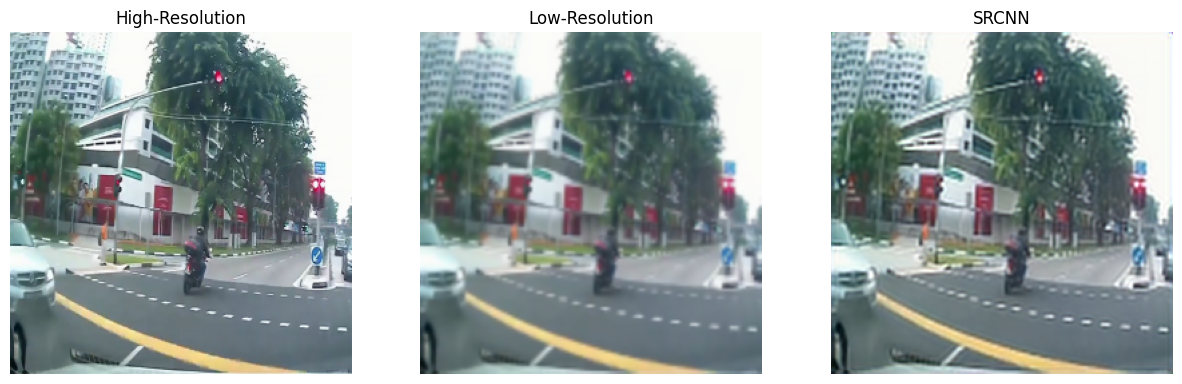

PSNR: 25.909445 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


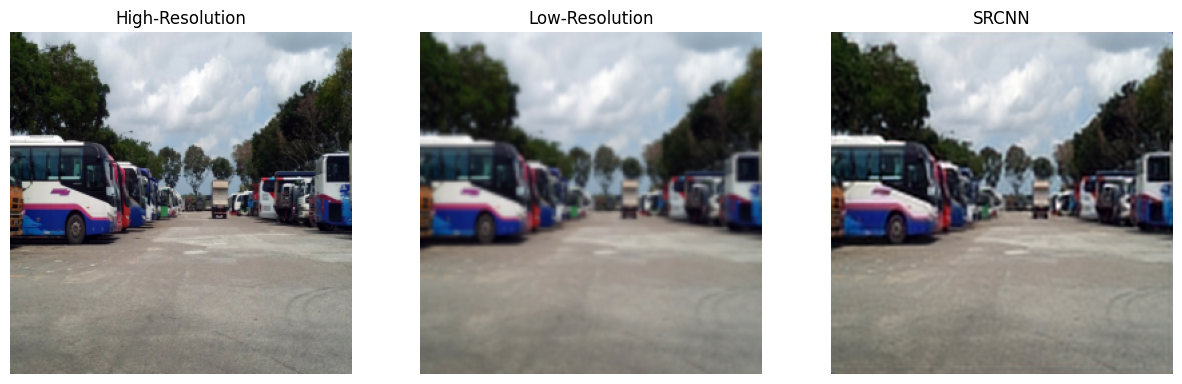

PSNR: 28.669397 dB


In [6]:
# Тестирање и визуелизација на резултатите користејќи го SRCNN моделот
def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('High-Resolution')
    plt.imshow(high)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low-Resolution')
    plt.imshow(low)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('SRCNN')
    plt.imshow(predicted)
    plt.axis('off')
    plt.show()

SRCNN = tf.keras.models.load_model("srcnn_model.h5", compile=False)
for i in range(5):
    predicted = np.clip(SRCNN.predict(test_low[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_images(test_high[i], test_low[i], predicted)
    print('PSNR:', psnr_metric(test_high[i], predicted).numpy(), 'dB')
